# Diamond Price Prediction


In [ ]:
!pip install opendatasets --upgrade --quiet

# Predicting diamond prices based on characteristics using linear regression and decision forest models.

 This dataset contains the characteristics and prices of over 50000 diamonds. In this notebook we will first explore clean and prepare the dataset to make it compatible for machine learning models. We will perform some exploratory data analysis to find any relationships or issues within the data. 
 
 After all the prepatory work is completed we will build a couple models to predict diamond prices. First we will build a simple linear model. After we establish baseline accuracy with the linear model we will build a more complex and optimized decision forest model. We will use some functions from `Sci-kit learn` to find our best hyperparameters.
 <hr>
 
 The **features** of this dataset are: 

1. carat -> carat weight of the diamond (0.2--5.01)

2. cut quality of the cut (Fair, Good, Very Good, Premium, Ideal)

3. color -> diamond colour, from J (worst) to D (best)

4. clarity -> measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))

5. depth -> total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
 
6. table -> width of top of diamond relative to widest point (43--95)
 
7. x -> length of Diamond in mm

8. y -> width of Diamond in mm

9. z -> depth of Diamond in mm


The **target value** is the price of the diamond in USD$.

## Section 1 - Download dataset from Kaggle and load into a Pandas DataFrame

<hr>

Here we will download the dataset from [Kaggle](https://www.kaggle.com/) using the utility module `opendatasets` which makes it easier to download the data and saves you some complicated steps. We will then load the data into a Pandas Dataframe and take an initial glance at it using the `head()`, `info()` and `describe()` methods from Pandas.

In [ ]:
import opendatasets as od
od.download('https://www.kaggle.com/datasets/ronil8/diamond-price-prediction-dataset')

Skipping, found downloaded files in "./diamond-price-prediction-dataset" (use force=True to force download)


In [ ]:
import pandas as pd
import numpy as np

In [ ]:
raw_df = pd.read_csv('./diamond-price-prediction-dataset/Diamond Price Prediction.csv')
raw_df.head()

,Carat(Weight of Daimond),Cut(Quality),Color,Clarity,Depth,Table,Price(in US dollars),X(length),Y(width),Z(Depth)
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Carat(Weight of Daimond)  53940 non-null  float64
 1   Cut(Quality)              53940 non-null  object 
 2   Color                     53940 non-null  object 
 3   Clarity                   53940 non-null  object 
 4   Depth                     53940 non-null  float64
 5   Table                     53940 non-null  float64
 6   Price(in US dollars)      53940 non-null  int64  
 7   X(length)                 53940 non-null  float64
 8   Y(width)                  53940 non-null  float64
 9   Z(Depth)                  53940 non-null  float64
dtypes: float64(6), int64(1), object(3)
memory usage: 4.1+ MB


In [ ]:
raw_df.describe()

,Carat(Weight of Daimond),Depth,Table,Price(in US dollars),X(length),Y(width),Z(Depth)
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,5.731157,5.734526,3.538734
std,0.474011,1.432621,2.234491,3989.439738,1.121761,1.142135,0.705699
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,4.710000,4.720000,2.910000
50%,0.700000,61.800000,57.000000,2401.000000,5.700000,5.710000,3.530000
75%,1.040000,62.500000,59.000000,5324.250000,6.540000,6.540000,4.040000
max,5.010000,79.000000,95.000000,18823.000000,10.740000,58.900000,31.800000


## Section 2 - Exploration, preparation and feature engineering.

<hr>

As we can see in **Section 1** every value in this dataset is valid. There are no missing or `NaN` values so we don't really have to do much in the way of cleaning this dataset. I suspect that this has already been taken care of by the dataset author or by people who have used and shared it after it was released.

We have a mix of numerical and categorical values to work with. The **cut**, **color** and **clarity** features will need to be encoded before we build the model. The remaining features as all numerical `float64` values which we may be able to use as is but will normalize if the results we get are not acceptable.

There are 3 features regarding diamond size **x (length)**, **y (width)** and **z (depth)**. We will multiply the 3 size features into one **Volume** feature and drop the individual measurments. Hopefully this will be sufficient enough for our models but if there are any issues we can come back and restore them.



Here I am going to rename the columns into simpler names. This isn't neccessary but I wrote the code for this on a different version of the same dataset and so rather than have to change a bunch of stuff I will just change the feature names.

In [ ]:
raw_df.rename(columns = {'Carat(Weight of Daimond)':'carat', 'Cut(Quality)':'cut', 'Color': 'color', 'Clarity': 'clarity', 'Depth': 'depth',
'Table': 'table', 'Price(in US dollars)': 'price', 'X(length)': 'x', 'Y(width)': 'y', 'Z(Depth)': 'z'}, inplace = True)

### Create **Volume** feature and drop **(X, Y, Z)** measurements.

Lets apply a `lambda` function to our dataset to multiply the measurements in volume.

In [ ]:
# Combine x * y * z to create Volume
raw_df['volume'] = raw_df.apply(lambda row : row['x'] * row['y'] * row['z'], axis=1)

In [ ]:
raw_df.columns

Index(['carat', 'cut', 'color', 'clarity', 'depth', 'table', 'price', 'x', 'y',
       'z', 'volume'],
      dtype='object')

Check our dataframe to check that our function worked correctly. We will manually compute a few volumes to ensure everything is Kosher.

In [ ]:
raw_df.head()

,carat,cut,color,clarity,depth,table,price,x,y,z,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43,38.202030
1,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31,34.505856
2,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31,38.076885
3,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63,46.724580
4,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75,51.917250


In [ ]:
print(f"Row 1: 3.95 * 3.98 * 2.43 == {3.95 * 3.98 * 2.43}\t correct!")
print(f"Row 3: 4.05 * 4.07 * 2.31 == {4.05 * 4.07 * 2.31}\t correct!")
print(f"Row 5: 4.34 * 4.35 * 2.75 == {4.34 * 4.35 * 2.75}\t correct!")

Row 1: 3.95 * 3.98 * 2.43 == 38.20203	 correct!
Row 3: 4.05 * 4.07 * 2.31 == 38.076885	 correct!
Row 5: 4.34 * 4.35 * 2.75 == 51.917249999999996	 correct!


Alright! looks like our new feature has worked out the way we intended. Now lets get rid of the 3 columns we no longer need by using the `DataFrame.drop()` method from Pandas. We will do it in place using the `inplace=True` value in the functions parameters. Note that we removal is done on the 1st axis, this will drop the entire column from the dataframe.

In [ ]:
raw_df.drop(['x', 'y', 'z'], axis=1, inplace=True)

And now to make sure everything worked correctly:

In [ ]:
raw_df.head(1)

,carat,cut,color,clarity,depth,table,price,volume
0,0.23,Ideal,E,SI2,61.5,55.0,326,38.20203


Now lets convert out target **price** from a `int64` data type to `float64`. I am not sure if this is neccesary or even of any benefit, but since monetary values are not whole numbers in the real world I figure it can't hurt and it is a very easy thing to do. We will use the `DataFrame.astype()` method to accomplish this.

In [ ]:
raw_df['price'] = raw_df['price'].astype('float64')

Did it work? Looks like it did.

In [ ]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53940 entries, 0 to 53939
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   carat    53940 non-null  float64
 1   cut      53940 non-null  object 
 2   color    53940 non-null  object 
 3   clarity  53940 non-null  object 
 4   depth    53940 non-null  float64
 5   table    53940 non-null  float64
 6   price    53940 non-null  float64
 7   volume   53940 non-null  float64
dtypes: float64(5), object(3)
memory usage: 3.3+ MB


### Encode our categorical features

**cut**, **color** and **clarity** will need to be encoded to work properly with our models. There are a couple ways we could go about doing this. The `Sci-kit Learn` preprocessing package comes with a `OneHotEncoder` class that converts categorical features into numerical representations. `Pandas` also has the `pandas.get_dummies()` function that more or less does the same thing. 

As this will change our original dataset substantially lets create a copy and work on that in case we want to use the original features in the visualization section next.

Lets start with **cut**...

Let see what unique values are included in our **cut** feature using the `unique()` dataframe method:

In [ ]:
data = raw_df.copy(deep=True)

In [ ]:
data['cut'].unique()

array(['Ideal', 'Premium', 'Good', 'Very Good', 'Fair'], dtype=object)

Alright we have 6 unique features. Now to encode them.

In [ ]:
data = pd.get_dummies(data, columns=['cut'])
data.head()

,carat,color,clarity,depth,table,price,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good
0,0.23,E,SI2,61.5,55.0,326.0,38.202030,0,0,1,0,0
1,0.21,E,SI1,59.8,61.0,326.0,34.505856,0,0,0,1,0
2,0.23,E,VS1,56.9,65.0,327.0,38.076885,0,1,0,0,0
3,0.29,I,VS2,62.4,58.0,334.0,46.724580,0,0,0,1,0
4,0.31,J,SI2,63.3,58.0,335.0,51.917250,0,1,0,0,0


Looks like it worked. Now to do the remaining features and then we will check it once more to ensure there are no issues.

In [ ]:
data = pd.get_dummies(data, columns=['color'])
data = pd.get_dummies(data, columns=['clarity'])

In [ ]:
pd.set_option('display.max_columns', None) # so we can see all our columns.
data.head()

,carat,depth,table,price,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,55.0,326.0,38.202030,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0
1,0.21,59.8,61.0,326.0,34.505856,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0.23,56.9,65.0,327.0,38.076885,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,0.29,62.4,58.0,334.0,46.724580,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0
4,0.31,63.3,58.0,335.0,51.917250,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0


### Data visualization

Before we create the model we will use `matplotlib` and `plotly express` to create some scatterplots and bar charts as well as `seaborn` to enhance the look and feel of our matplotlib visualizations. While the original styling is not without its charm I prefer using the `darkgrid` theme from seaborn. 

First lets import our librarys... 

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import matplotlib

sns.set_style('darkgrid')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams['figure.facecolor'] = '#00000000'
%matplotlib inline

For our first visualization lets use `plotly.express.scatter()` to make an interactive and beautiful scatterplot showing the relationship between the weight of the diamond and its price.

We will also create a histogram showing the distribution of the carat feature using `matplotlib` and `seaborn` with a **Kernel Density Estimate** curve included.

In [ ]:
carat_scatter = px.scatter(raw_df,
                           x='carat', 
                           y='price',
                           template='plotly_dark', 
                           color='cut',  
                           opacity=0.5,
                           title='Diamond Price Based On Carat(Weight)')
carat_scatter.show()

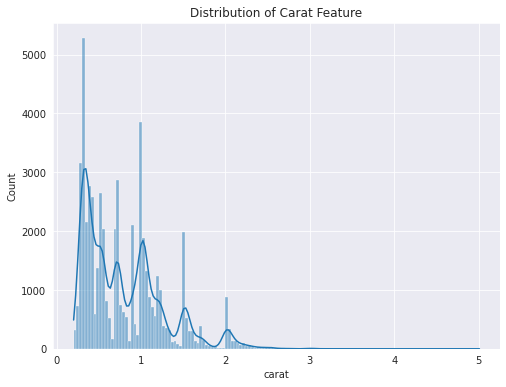

In [ ]:
plt.figure(figsize=(8, 6))
sns.histplot(data=raw_df, 
             x='carat',
             kde=True)
plt.title('Distribution of Carat Feature')
plt.show()

Now lets see how our **volume** feature is related to the diamonds price.

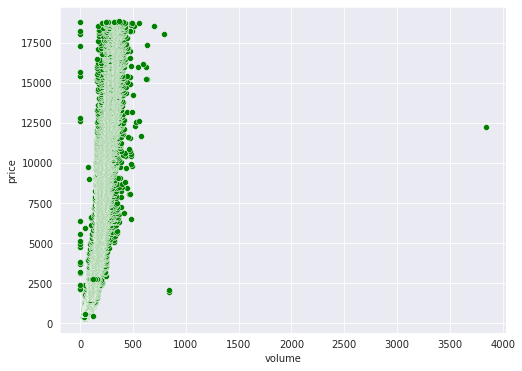

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['volume'], y=data['price'], color='green');

Looks like we have an outlier that may cause us problems down the road. We can afford to just get rid of it so we will do that here. Lets look at the stats using `describe()` and find the max value for **volume** and then remove it using a conditional statement in pandas.

In [ ]:
data.describe()

,carat,depth,table,price,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
count,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000,53940.000000
mean,0.797940,61.749405,57.457184,3932.799722,129.849403,0.029848,0.090953,0.399537,0.255673,0.223990,0.125603,0.181628,0.176900,0.209344,0.153949,0.100519,0.052058,0.013737,0.033185,0.242214,0.170449,0.151483,0.227253,0.067760,0.093919
std,0.474011,1.432621,2.234491,3989.439738,78.245262,0.170169,0.287545,0.489808,0.436243,0.416919,0.331404,0.385541,0.381588,0.406844,0.360903,0.300694,0.222146,0.116400,0.179121,0.428427,0.376030,0.358522,0.419061,0.251337,0.291719
min,0.200000,43.000000,43.000000,326.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.400000,61.000000,56.000000,950.000000,65.136830,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.700000,61.800000,57.000000,2401.000000,114.808572,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.040000,62.500000,59.000000,5324.250000,170.842451,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.010000,79.000000,95.000000,18823.000000,3840.598060,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [ ]:
data = data[data['volume'] < 697.1]

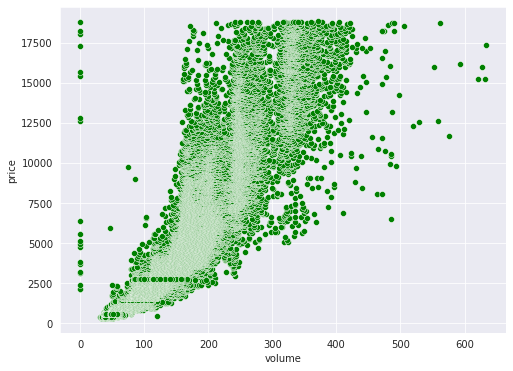

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['volume'], y=data['price'], color='green');

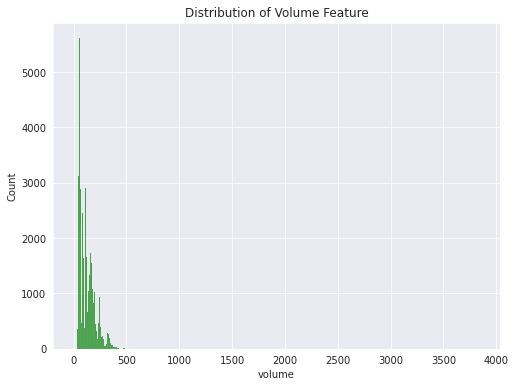

In [ ]:
plt.figure(figsize=(8, 6))
sns.set_style('darkgrid')
sns.histplot(data=raw_df, 
             x='volume',
             kde=False,
             color='green')
plt.title('Distribution of Volume Feature')
plt.show()

Lets if **table** and **volume** are related and then see if **table** has a linear relationship to the price.

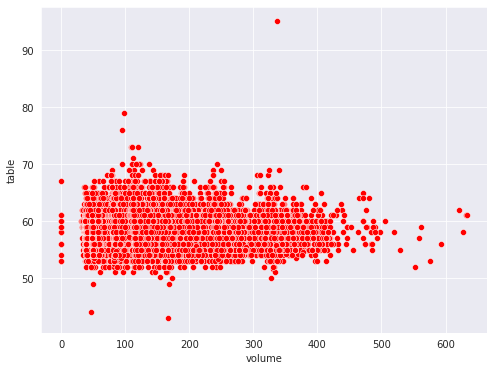

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['volume'], y=data['table'], color='red');

Looks like there is no obvious relationship between **table** and **volume** so lets see about price.

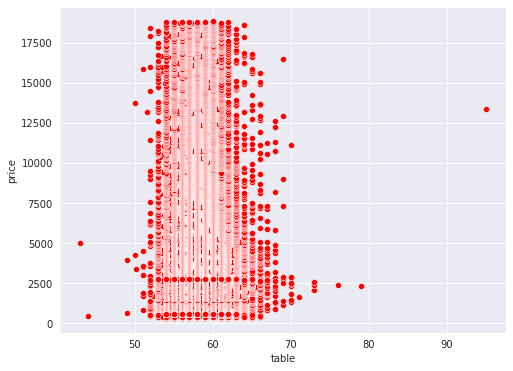

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['table'], y=data['price'], color='red');

It appears that **table** won't be of much use for our purposes so lets drop it.

In [ ]:
data.drop('table', axis=1, inplace=True)
data.head(1)

,carat,depth,price,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,61.5,326.0,38.20203,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


The last feature we will visualize is **depth**. As we have done above we will look at its relationship to **price**.

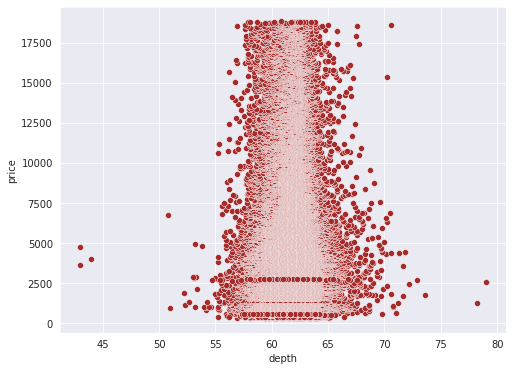

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x=data['depth'], y=data['price'], color='brown');

Doesn't look like **depth** is going to help us either so we will get rid of it as well.

In [ ]:
data.drop('depth', axis=1, inplace=True)
data.head(1)

,carat,price,volume,cut_Fair,cut_Good,cut_Ideal,cut_Premium,cut_Very Good,color_D,color_E,color_F,color_G,color_H,color_I,color_J,clarity_I1,clarity_IF,clarity_SI1,clarity_SI2,clarity_VS1,clarity_VS2,clarity_VVS1,clarity_VVS2
0,0.23,326.0,38.20203,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 53935 entries, 0 to 53939
Data columns (total 23 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   carat          53935 non-null  float64
 1   price          53935 non-null  float64
 2   volume         53935 non-null  float64
 3   cut_Fair       53935 non-null  uint8  
 4   cut_Good       53935 non-null  uint8  
 5   cut_Ideal      53935 non-null  uint8  
 6   cut_Premium    53935 non-null  uint8  
 7   cut_Very Good  53935 non-null  uint8  
 8   color_D        53935 non-null  uint8  
 9   color_E        53935 non-null  uint8  
 10  color_F        53935 non-null  uint8  
 11  color_G        53935 non-null  uint8  
 12  color_H        53935 non-null  uint8  
 13  color_I        53935 non-null  uint8  
 14  color_J        53935 non-null  uint8  
 15  clarity_I1     53935 non-null  uint8  
 16  clarity_IF     53935 non-null  uint8  
 17  clarity_SI1    53935 non-null  uint8  
 18  clarit

## Section 3 - Prepare data for model

Before we build our models we need to randomly shuffle the data and split it into training, validation and testing subsets. Both the randomization and the splitting can be accomplished using `sklearn.model_selection.train_test_split()`. After splitting we will further divide the subsets into feature and target sets.

In [ ]:
from sklearn.model_selection import train_test_split

First we will split the data into training and testing/validation datasets. Next we will split the testing/validation set into individual testing and validation sets.

In [ ]:
train_df, test_val_df = train_test_split(data, test_size=0.2, random_state=1987)
test_df, val_df = train_test_split(test_val_df, test_size=0.5, random_state=1987)

print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (43148, 23)
val_df.shape : (5394, 23)
test_df.shape : (5393, 23)


Alright those proportions look acceptable. Now let's move the **price** values into separate target sets. This will be done on all 3 subsets.

In [ ]:
x_train = train_df.drop('price', axis=1, inplace=False)
y_train = train_df['price']

x_val = val_df.drop('price', axis=1, inplace=False)
y_val = val_df['price']

x_test = test_df.drop('price', axis=1, inplace=False)
y_test = test_df['price']

Double check that everything looks as expected...

In [ ]:
print(f"x_train shape: {x_train.shape}\ty_train shape: {y_train.shape}")

print(f"x_val shape: {x_val.shape}\ty_val shape: {y_val.shape}")

print(f"x_test shape: {x_test.shape}\ty_test shape: {y_test.shape}")

x_train shape: (43148, 22)	y_train shape: (43148,)
x_val shape: (5394, 22)	y_val shape: (5394,)
x_test shape: (5393, 22)	y_test shape: (5393,)


## Section 4 - Model building
<hr> 

In this section we will build 4 models. The first model will be a simple linear regression model using only the **volume** feature to try and predict price. This will give us a good baseline for subsequent models.

The second model will be also be a linear regression model except this time we will include all the features when fitting to the data. 

The third model will be a random forest regressor, which trains multiple decision tree models and averages their results which usually gives better results than a single decision tree. For this model we will not use any external utilities to optimize our model.

The final model we will produce will also be a decision forest, but this time we will utilize some utility functions from `Sci-kit learn` to find the optimal hyperparameters for our model.



### Simple linear regression model

We are going to use the `LinearRegression` class from `sklearn.linear_model` to build our first two models. As is the case with many of Sci-kit Learns algorithms LinearRegression() is simple to implement while also being effective for many machine learning problems. We just need to instantiate the model and fit it to the data.

For our single feature version we will make a simple dataset consisting of the **volume** feature only.

In [ ]:
from sklearn.linear_model import LinearRegression

Let's create our subset from the x_train data.

In [ ]:
x_train_subset = pd.DataFrame(x_train['volume'])

In [ ]:
simple_linear_model = LinearRegression().fit(x_train_subset, y_train)

Now let's make predictions using our model and then plot the results to see how it performs. As this is just a starter model we will not be using the testing or validation sets as we are not concerned with optimizing its performance.

In [ ]:
simple_preds = simple_linear_model.predict(x_train_subset)
simple_preds

array([ 571.42482001, 6782.03638629, 6432.55132164, ...,  720.2706015 ,
       1509.71356586,  993.82947113])

In [ ]:
y_train

We will need a way to measure our models loss value. For this task Sci-kit Learn provides the `sklearn.metrics.mean_squared_error` method to calculate ... ... the mean squared error! We will set `squared=False` so as to get a root mean squared error. 

In [ ]:
from sklearn.metrics import mean_squared_error

In [ ]:
base_rmse = mean_squared_error(y_train, simple_preds, squared=False)
print(f"simple_linear_model RMSE: {base_rmse}")

simple_linear_model RMSE: 1547.363694131629


Now to plot our models predictions with the actual values 

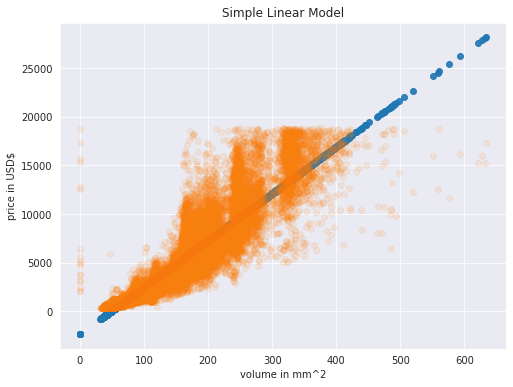

simple_linear_model RMSE: 1547.363694131629


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train_subset, simple_preds, alpha=0.9)
plt.scatter(x_train_subset, y_train, alpha=0.1)
plt.xlabel('volume in mm^2')
plt.ylabel('price in USD$')
plt.title('Simple Linear Model')
plt.show()
print(f"simple_linear_model RMSE: {base_rmse}")

Alright, not half bad! Our simple linear model is able to predict diamond prices using volume with a RMSE loss of around 1550. Now we can move on to more advanced models and see if we can achieve better results.

### Full linear regression model

Building our complete linear regression model will be identical to the previous one except we will use our full training data. We will also try it out on our validation data to get a more accurate idea of how it is performing.

In [ ]:
linear_model = LinearRegression().fit(x_train, y_train)

In [ ]:
lin_train_preds = linear_model.predict(x_train)
lin_val_preds = linear_model.predict(x_val)

lin_train_rmse = mean_squared_error(y_train, lin_train_preds, squared=False)
lin_val_rmse = mean_squared_error(y_val, lin_val_preds, squared=False)

print(f"linear model training rmse: {lin_train_rmse}")
print(f"linear model val rmse: {lin_val_rmse}")

linear model training rmse: 1156.6169853627885
linear model val rmse: 1130.2257538955655


Awesome! Looks like our linear regression model is doing alright. Our RMSE values are lower than our base model on both the training and validation datasets. This is a good sign. Lets plot our results to get a visual appreciation of our models performance. 

As we can't visually show 2 dimensional data we will use our **volume** feature again as we did in the previous visualizations.

First the training data:

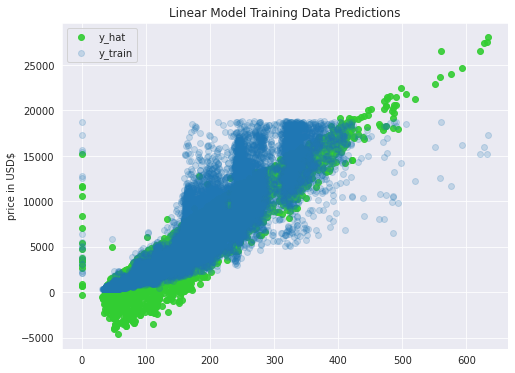

-------------------------------------------------
linear model training RMSE: 1156.6169853627885
-------------------------------------------------


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train['volume'], lin_train_preds, alpha=0.9, label='y_hat', c='limegreen')
plt.scatter(x_train['volume'], y_train, alpha=0.2, label='y_train')
plt.ylabel('price in USD$')
plt.title('Linear Model Training Data Predictions')
plt.legend()
plt.show()
print('-------------------------------------------------')
print(f"linear model training RMSE: {lin_train_rmse}")
print('-------------------------------------------------')

And now the validation data:

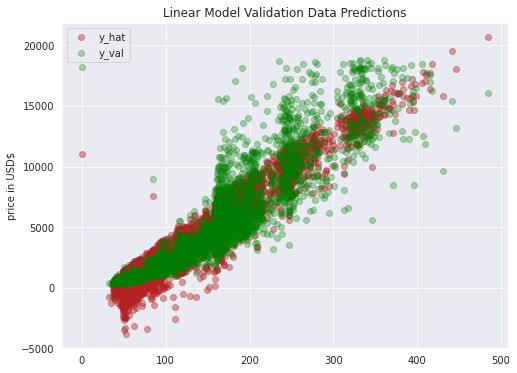

-------------------------------------------------
linear model validation RMSE: 1130.2257538955655
-------------------------------------------------


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_val['volume'], lin_val_preds, alpha=0.4, label='y_hat', c='firebrick')
plt.scatter(x_val['volume'], y_val, alpha=0.3, label='y_val', c='green')
plt.ylabel('price in USD$')
plt.title('Linear Model Validation Data Predictions')
plt.legend()
plt.show()
print('-------------------------------------------------')
print(f"linear model validation RMSE: {lin_val_rmse}")
print('-------------------------------------------------')

Before we go any further let us start storing our loss values in

In [ ]:
RMSE_VALUES = [
    {'simple linear model': base_rmse},
    {'linear model training': lin_train_rmse},
    {'linear model validation': lin_val_rmse}
]
print(RMSE_VALUES)

[{'simple linear model': 1547.363694131629}, {'linear model training': 1156.6169853627885}, {'linear model validation': 1130.2257538955655}]


Ooh that is an ugly output from the vanilla python print function. We will import `pprint` a pretty printing module for python.

In [ ]:
from pprint import pprint
pprint(RMSE_VALUES)

[{'simple linear model': 1547.363694131629},
 {'linear model training': 1156.6169853627885},
 {'linear model validation': 1130.2257538955655}]


### Base Random Forest Regressor model

Here is where things get interesting. We will use an ensemble training algorithm from Sci-kit learn called the `RandomForestRegressor`. While this is a more complex model than linear regression, the process for creating, fitting and predicting are basically identical to what we did previously. That is the great thing about Sci-kit Learn. As opposed to other frameworks like Tensorflow/Keras and PyTorch where the process to build a model depends on the algorithm, in Sci-kit Learn everything follows a standard format so changing to a different algorithm does not require learning a completely different process.

In [ ]:
from sklearn.ensemble import RandomForestRegressor
base_forest_model = RandomForestRegressor(random_state=1987).fit(x_train, y_train)

As you can see this model takes longer to train as it is much more complex than the linear regression model. It should give us better results however, as it has a deeper understanding of the data.

In [ ]:
base_forest_train_preds = base_forest_model.predict(x_train)
base_forest_train_rmse = mean_squared_error(y_train, base_forest_train_preds, squared=False)

base_forest_val_preds = base_forest_model.predict(x_val)
base_forest_val_rmse = mean_squared_error(y_val, base_forest_val_preds, squared=False)

In [ ]:
print(f"base forest training rmse: {base_forest_train_rmse}")
print(f"base forest validation rmse: {base_forest_val_rmse}")

base forest training rmse: 217.4969670445169
base forest validation rmse: 549.1816451222655


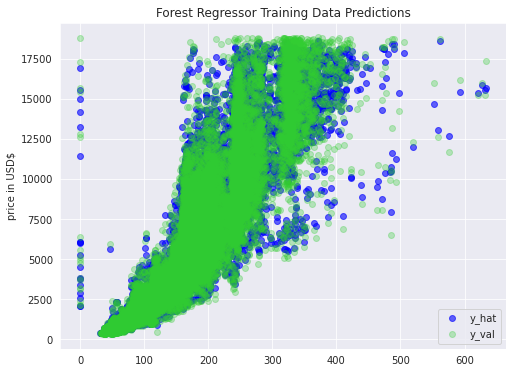

-------------------------------------------------
forest regressor training RMSE: 217.4969670445169
-------------------------------------------------


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_train['volume'], base_forest_train_preds, alpha=0.6, label='y_hat', c='blue')
plt.scatter(x_train['volume'], y_train, alpha=0.3, label='y_val', c='limegreen')
plt.ylabel('price in USD$')
plt.title('Forest Regressor Training Data Predictions')
plt.legend()
plt.show()
print('-------------------------------------------------')
print(f"forest regressor training RMSE: {base_forest_train_rmse}")
print('-------------------------------------------------')

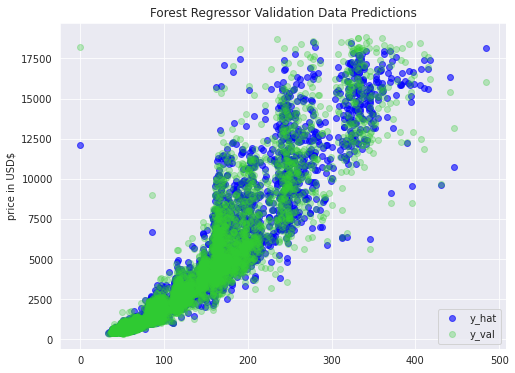

-------------------------------------------------
forest regressor validation RMSE: 549.1816451222655
-------------------------------------------------


In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(x_val['volume'], base_forest_val_preds, alpha=0.6, label='y_hat', c='blue')
plt.scatter(x_val['volume'], y_val, alpha=0.3, label='y_val', c='limegreen')
plt.ylabel('price in USD$')
plt.title('Forest Regressor Validation Data Predictions')
plt.legend()
plt.show()
print('-------------------------------------------------')
print(f"forest regressor validation RMSE: {base_forest_val_rmse}")
print('-------------------------------------------------')

In [ ]:
RMSE_VALUES.append({
    'base forest regr training': base_forest_train_rmse
})
RMSE_VALUES.append({
    'base forest regr validation': base_forest_val_rmse
})

pprint(RMSE_VALUES)

[{'simple linear model': 1547.363694131629},
 {'linear model training': 1156.6169853627885},
 {'linear model validation': 1130.2257538955655},
 {'base forest regr training': 217.4969670445169},
 {'base forest regr validation': 549.1816451222655}]


As we can see our Random Forest Regressor model is outperforming both our linear models significantly! There is a speed tradeoff but I think the results speak for themselves. Now we can move on to our final model.

### Optimized Random Forest Regressor

For this model we are pulling out the big guns. `RandomizedSearchCV` and `GridSearchCV` from Sci-kit Learn can be used to find the optimal hyperparameters to use in a model. First we will use `RandomizedSearchCV` with a range of hyperparameters to test various configurations and find which hyperparameter values produce the best results. 

We will use the results from the random search to narrow down our tuning and use `GridSearchCV` to optimize our model. 

#### RandomizedSearchCV

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

First we need to create a parameter grid for the randomized search to use during the tuning process. This grid contains the range of values that will be used.

We are going to tune the following parameters:
- n_estimators: number of trees/estimators
- max_features: number of features to consider a split
- max_depth: the maximum number of levels in the trees
- min_samples_split: minimum samples to split each node
- min_samples_leaf: minimum samples required at each node
- bootstrap: method for selecting samples for training 

In [ ]:
# number of trees/estimators
n_estimators = [int(x) for x in np.linspace(start=20, stop=160, num=5)]

# number of features to consider at split
max_features = ['auto', 'sqrt']

# max levels in tree
max_depth = [int(x) for x in np.linspace(10, 150, num=5)]
max_depth.append(None)

# min samples required to split node
min_samples_split = [2, 5, 10]

# min samples required at each leaf node
min_samples_leaf = [1, 2, 4]

# method of selecting samples for training each tree
bootstrap = [True, False]

# create grid
random_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

pprint(random_grid)

{'bootstrap': [True, False],
 'max_depth': [10, 45, 80, 115, 150, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [20, 55, 90, 125, 160]}


Now we will need to instantiate a random forest regressor model, a search model and fit the data to the search model which will contain the random forest model.

This will use 3 fold cross validation and will search across 50 combinations using all available cpu cores.

This will take around 20 minutes to run so go grab a coffe or fire up youtube or something.

In [ ]:
# random search of parameters using 3 fold cross validation
# search across 50 combinations using all cores
tuning_model = RandomForestRegressor()
rf_random = RandomizedSearchCV(
    estimator=tuning_model,
    param_distributions=random_grid,
    n_iter=50,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# fit search model
rf_random.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits


/usr/local/lib/python3.7/dist-packages/joblib/externals/loky/process_executor.py:705: UserWarning:

A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.



RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 45, 80, 115, 150,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [20, 55, 90, 125, 160]},
                   random_state=42, verbose=2)

Alright! Now that our first optimization method has finished we can check for the best values in `rf_random.best_params`.

In [ ]:
rf_random.best_params_

{'n_estimators': 55,
 'min_samples_split': 10,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 150,
 'bootstrap': True}

Now we can use these values as the starting point to further optimize our model.
```
{'bootstrap': True,
 'max_depth': 150,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 55}
```

Lets save these values into an object for later use.

In [ ]:
best_hyperparams = {'bootstrap': True,
 'max_depth': 150,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 55}

To compare out optimized model to the base model we will use this evaluate function by Will Koehrsen that can be found [in this article](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)

In [ ]:
def evaluate(model, test_features, test_labels):
  predictions = model.predict(test_features)
  errors = abs(predictions - test_labels)
  mape = 100 * np.mean(errors / test_labels)
  accuracy = 100 - mape
  print('Model Performance')
  print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
  print('Accuracy = {:0.2f}%.'.format(accuracy))

  return accuracy

Now we can check our base model accuracy and our optimized model accuracy.

In [ ]:
base_model = RandomForestRegressor(n_estimators=10, random_state=42).fit(x_train, y_train)
base_accuracy = evaluate(base_model, x_val, y_val)

Model Performance
Average Error: 295.9126 degrees.
Accuracy = 91.10%.


In [ ]:
best_random = rf_random.best_estimator_
random_accuracy = evaluate(best_random, x_val, y_val)

Model Performance
Average Error: 281.9928 degrees.
Accuracy = 91.76%.


Alright! While we didn't get a huge boost we still gained some accuracy. Depending on the task that may or may not matter.

#### Save and/or load the model

Since the RandomizedSearchCV method took a while to run we can save the model here and reload it later to start off at this point instead of having to rerun the training. We will use the `pickle` module to save our model into a byte stream.

Uncomment the following 2 cells to save or load the model

In [ ]:
# import pickle

# # save to file
# pkl_filename = 'best_random.pkl'
# with open(pkl_filename, 'wb') as file:
#   pickle.dump(best_random, file)

In [ ]:
# # reload saved model
# with open(pkl_filename, 'rb') as file:
#   best_random = pickle.load(file)

#### GridSearchCV
<hr>

GridSearchCV is an other optimizing algorithm and follows the same syntax as most other Sci-kit Learn modules so I won't go into much detail here. There is ample information in the docs so look there for more detail. Essentially it performs an "exhaustive search over specified parameter values for an estimator". 

In [ ]:
from sklearn.model_selection import GridSearchCV

As we did previously we will create a parameter grid, this time using the data from our previous search to infer the range of parameter values to search over.

Once again here are the values from our last optimization
```
{'bootstrap': True,
 'max_depth': 150,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 55}
```

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': [140, 150, 155, 160],
    'max_features': ['auto'],
    'min_samples_leaf': [1, 2, 4],
    'min_samples_split': [10, 15, 20],
    'n_estimators': [55, 75, 100]
 }

And now to instantiate and fit the estimator to our data.

In [ ]:
# create base model 
rf = RandomForestRegressor()

# instantiate grid search
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=3,
    n_jobs=-1,
    verbose=2
)

In [ ]:
# fit grid to data
grid_search.fit(x_train, y_train)

Fitting 3 folds for each of 108 candidates, totalling 324 fits


GridSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [140, 150, 155, 160],
                         'max_features': ['auto'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [10, 15, 20],
                         'n_estimators': [55, 75, 100]},
             verbose=2)

As above we can check our best performing values

In [ ]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 155,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 75}

Best values:
```
{'bootstrap': True,
 'max_depth': 155,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 10,
 'n_estimators': 75}
```

Now instead of having to manually input the best parameters we can just get the model from our estimator as it has already been saved. Just assign the `best_estimator_` value to a new variable for out model

In [ ]:
best_grid = grid_search.best_estimator_

Almost done, now to check our validation accuracy

In [ ]:
grid_accuracy = evaluate(best_grid, x_val, y_val)

Model Performance
Average Error: 284.3549 degrees.
Accuracy = 91.73%.


## Section 5 - Run Best Model On Test Data

Before wrapping up lets run our best model on the unseen testing dataset `x_test, y_test`

In [ ]:
test_accuracy = evaluate(best_grid, x_test, y_test)

Model Performance
Average Error: 277.3085 degrees.
Accuracy = 91.77%.


Looks like our model does a decent job of predicting diamond prices based on physical characteristics. Not perfect but a score of over 90% on the test data for this sort of task is probably acceptable. 

Data --> Model --> ... --> Money?

## Section 6 - Save the model

## Section 7 - References

In [ ]:
import pickle

# save to file
pkl_filename = 'best_grid.pkl'
with open(pkl_filename, 'wb') as file:
  pickle.dump(best_grid, file)

Uncomment the following cell to load a save model.

In [ ]:
# # reload saved model
# with open(pkl_filename, 'rb') as file:
#   best_random = pickle.load(file)

I did not venture very far from the documentation for this project. But I will list some sources here.

1. [Linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html)

2. [Random forest regressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)

3. [RandomizedSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)

4. [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

5. [Various ML tutorials and topics at Jovian](https://jovian.ai/)

6. [Hyperparameter tuning and accuracy function for random forest regressors](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)